/home/mat/.cache/pypoetry/virtualenvs/jax-image-segmentation-unet-QTjRpPEx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


JAX process: 1 / 1
JAX local devices: [CudaDevice(id=0)]
Input: (112, 112, 1)


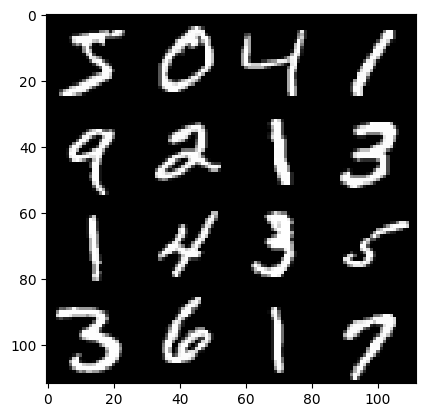

True one-hot channel masks: (112, 112, 11)


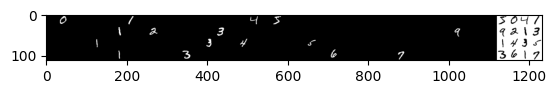

True segmentation: (112, 112, 11)


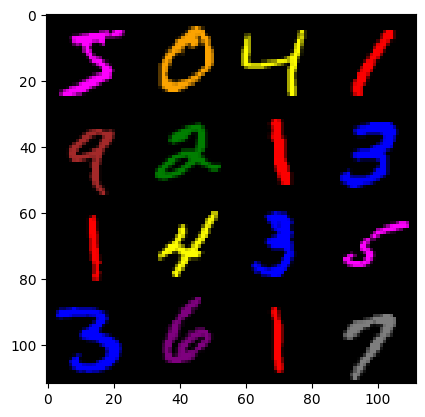

Untrained model, random weights:
Predicted one-hot channel masks: (112, 112, 11)


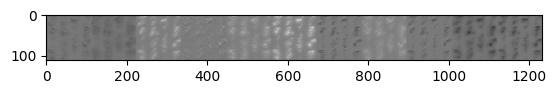

Predicted segmentation: (112, 112, 11)


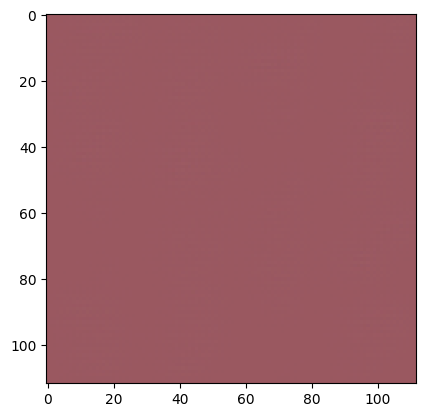

/home/mat/.cache/pypoetry/virtualenvs/jax-image-segmentation-unet-QTjRpPEx-py3.10/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1442: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Using model checkpoint from /home/mat/ml/jax-image-segmentation-unet/jax_image_segmentation_unet/.trained_checkpoint
(Trained model) predicted one-hot channel masks: (112, 112, 11)


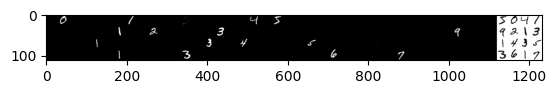

(Trained model) predicted segmentation: (112, 112, 11)


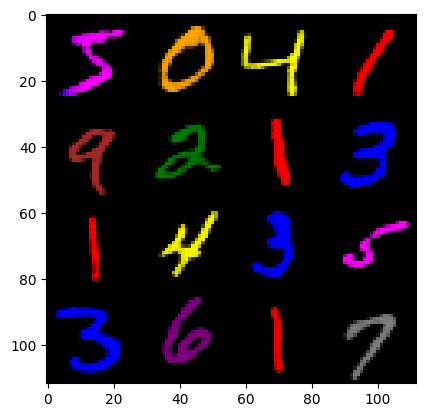

In [1]:
import jax.numpy as jnp
import jax

from train import jax_cache_dir

jax.config.update("jax_compilation_cache_dir", jax_cache_dir)
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

import os
from orbax.checkpoint import PyTreeCheckpointer
import asyncio
import optax

from mnist_grid_dataset import MnistGridDataset
from model import SegmentationUNet
from visualization import to_rgb
from train import checkpoint_path, Metrics, TrainState
import matplotlib.pyplot as plt


dataset = MnistGridDataset()

input, true_seg = dataset[0]


def display_one_hot(x: jax.Array):
    bw_imgs = jnp.split(x, x.shape[-1], axis=-1)
    grid = jnp.concatenate(bw_imgs, axis=1)
    plt.imshow(grid, cmap="gray")
    plt.show()


def display_rgb_segmented(x: jax.Array):
    rgb_true = jnp.einsum("bwhc,cr->bwhr", jnp.expand_dims(x, 0), to_rgb).squeeze()
    plt.imshow(rgb_true)
    plt.show()


print("Input:", input.shape)
plt.imshow(input, cmap="gray")
plt.show()

print("True one-hot channel masks:", true_seg.shape)
display_one_hot(true_seg)

print("True segmentation:", true_seg.shape)
display_rgb_segmented(true_seg)

rng = jax.random.PRNGKey(0)

seg_model = SegmentationUNet(in_channels=1, num_classes=10)
x = jnp.expand_dims(input, 0)
model_vars = seg_model.init(rng, x, train=False)

print("Untrained model, random weights:")
pred = seg_model.apply(model_vars, x, train=False).squeeze(0)
print("Predicted one-hot channel masks:", pred.shape)
display_one_hot(pred)

print("Predicted segmentation:", pred.shape)
display_rgb_segmented(pred)


if os.path.exists(checkpoint_path):
    orbax_checkpointer = PyTreeCheckpointer()

    async def restore_checkpoint(target):
        restored = orbax_checkpointer.restore(checkpoint_path, item=target)
        return restored

    empty_state = TrainState.create(
        apply_fn=seg_model.apply,
        params=model_vars["params"],  # values of the tree leaf doesn't matter
        tx=optax.adamw(1e-3),
        metrics=Metrics.empty(),
        batch_stats=model_vars["batch_stats"],
    )
    empty_config = {"dimensions": jnp.array([0, 0])}

    loop = asyncio.get_event_loop()
    target = {
        "model": empty_state,
    }
    state_restored = loop.run_until_complete(restore_checkpoint(target=target))

    print(f"Using model checkpoint from {checkpoint_path}")
    pred = seg_model.apply(
        {
            "params": state_restored["model"].params,
            "batch_stats": state_restored["model"].batch_stats,
        },
        x,
        train=False,
    )
    pred = pred.squeeze(0)
    print("(Trained model) predicted one-hot channel masks:", pred.shape)
    display_one_hot(pred)
    print("(Trained model) predicted segmentation:", pred.shape)
    display_rgb_segmented(pred)

else:
    print(
        f"No model checkpoint found at {checkpoint_path}. Run train.py first to see the trained model's predicions."
    )